# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [6]:
import pandas as pd
import numpy as np

files = {
    "Panama City": "data/PanamaCityWeather.csv",
    "Gainesville": "data/GainsvilleWeather.csv",
    "Miami": "data/MiamiWeather.csv",
    "Orlando": "data/OrlandoWeather.csv",
    "Tampa": "data/TampaWeather.csv"
}
dfs = []
for city, file_path in files.items():
    df = pd.read_csv(file_path)
    df['City'] = city
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)
#clean up white spaces
combined_df.columns = combined_df.columns.str.strip()
# change -99 to nan to rmeove later
combined_df.replace([-99.9, -99.99], np.nan, inplace=True)

combined_df['Date'] = pd.to_datetime(
    combined_df[['YEAR', 'MONTH', 'DAY']].rename(columns={
        'YEAR': 'year', 'MONTH': 'month', 'DAY': 'day'
    }),
    errors='coerce'
)
# remove any of the -99
combined_df.dropna(subset=['Date'], inplace=True)
#remove any of the -99
combined_df_clean = combined_df.dropna(subset=["PRECIPITATION", "MAX TEMP", "MIN TEMP", "MEAN TEMP"])

combined_df_clean.reset_index(drop=True, inplace=True)

print(combined_df_clean.head())


   COOPID  YEAR  MONTH  DAY  PRECIPITATION  MAX TEMP  MIN TEMP  MEAN TEMP  \
0   83326  1960      5   17            0.0      90.0      64.0       77.0   
1   83326  1960      5   18            0.0      92.0      62.0       77.0   
2   83326  1960      5   19            0.0      94.0      59.0       76.5   
3   83326  1960      5   20            0.0      89.0      68.0       78.5   
4   83326  1960      5   21            0.0      91.0      65.0       78.0   

          City       Date  
0  Panama City 1960-05-17  
1  Panama City 1960-05-18  
2  Panama City 1960-05-19  
3  Panama City 1960-05-20  
4  Panama City 1960-05-21  


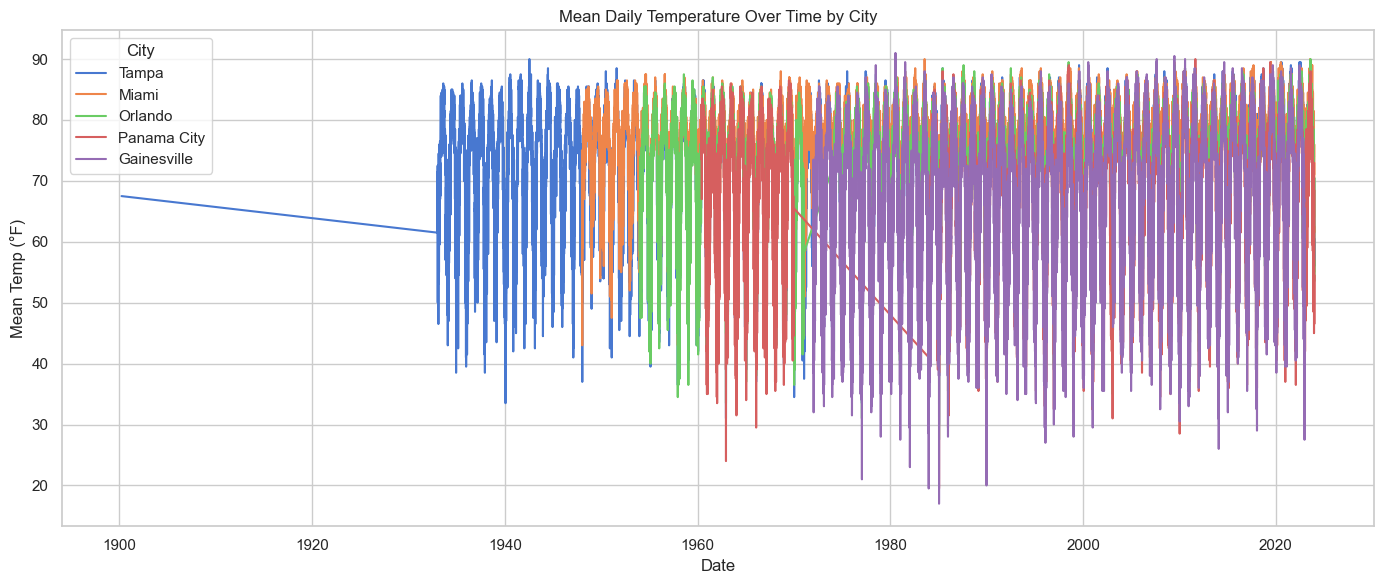

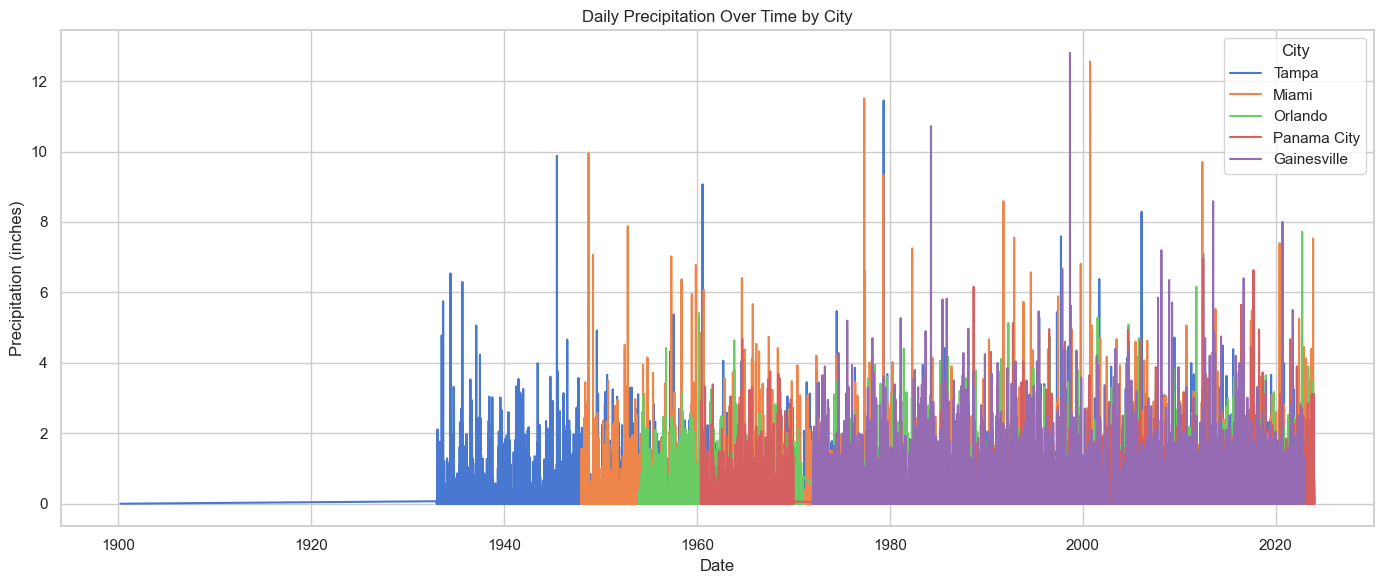

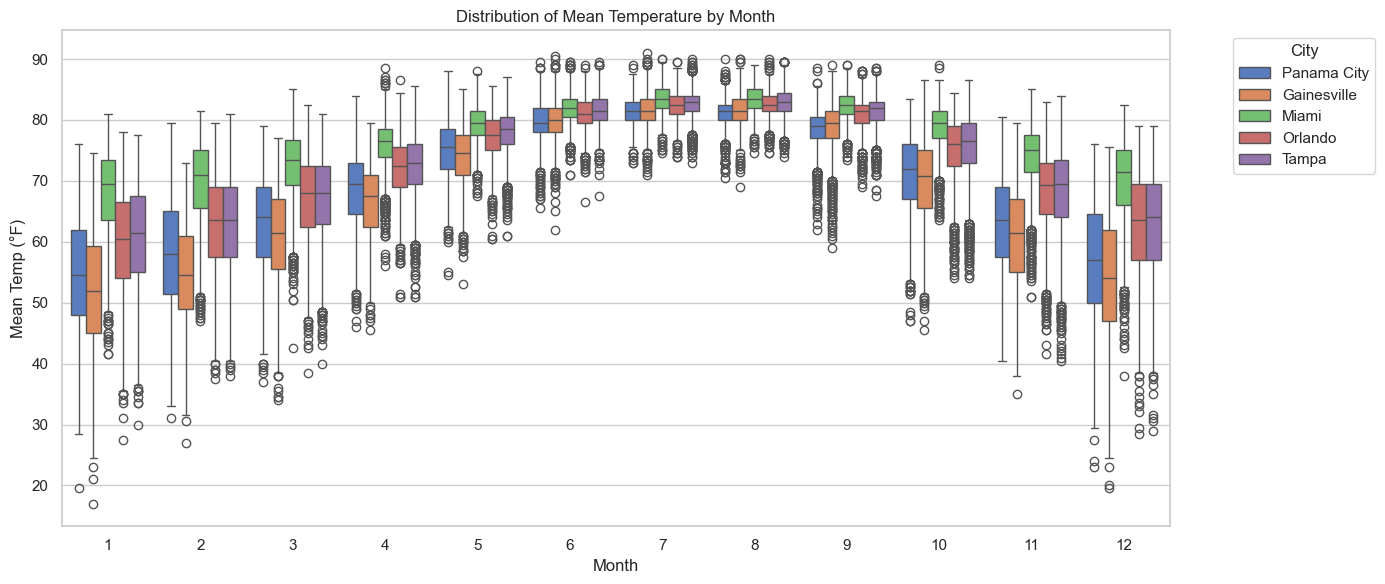

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (12, 6)

city_daily_avg = combined_df_clean.groupby(['Date', 'City']).agg({
    'PRECIPITATION': 'mean',
    'MEAN TEMP': 'mean',
    'MAX TEMP': 'mean',
    'MIN TEMP': 'mean'
}).reset_index()

#mean temp over time but again doesnt look great
plt.figure(figsize=(14, 6))
sns.lineplot(data=city_daily_avg, x='Date', y='MEAN TEMP', hue='City')
plt.title("Mean Daily Temperature Over Time by City")
plt.xlabel("Date")
plt.ylabel("Mean Temp (°F)")
plt.legend(title='City')
plt.tight_layout()
plt.show()

#precipitation over time but it doesnt look great
plt.figure(figsize=(14, 6))
sns.lineplot(data=city_daily_avg, x='Date', y='PRECIPITATION', hue='City')
plt.title("Daily Precipitation Over Time by City")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.legend(title='City')
plt.tight_layout()
plt.show()

#box plot of temp by month idk if this helps?
combined_df_clean.loc[:, 'Month'] = combined_df_clean['Date'].dt.month

plt.figure(figsize=(14, 6))
sns.boxplot(data=combined_df_clean, x='Month', y='MEAN TEMP', hue='City')
plt.title("Distribution of Mean Temperature by Month")
plt.xlabel("Month")
plt.ylabel("Mean Temp (°F)")
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



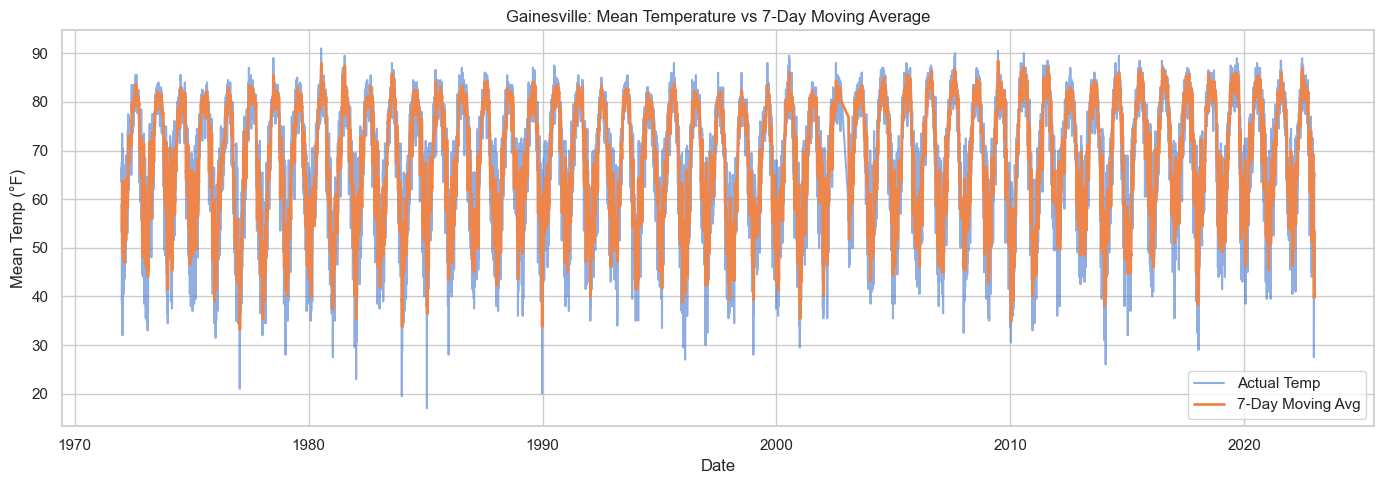

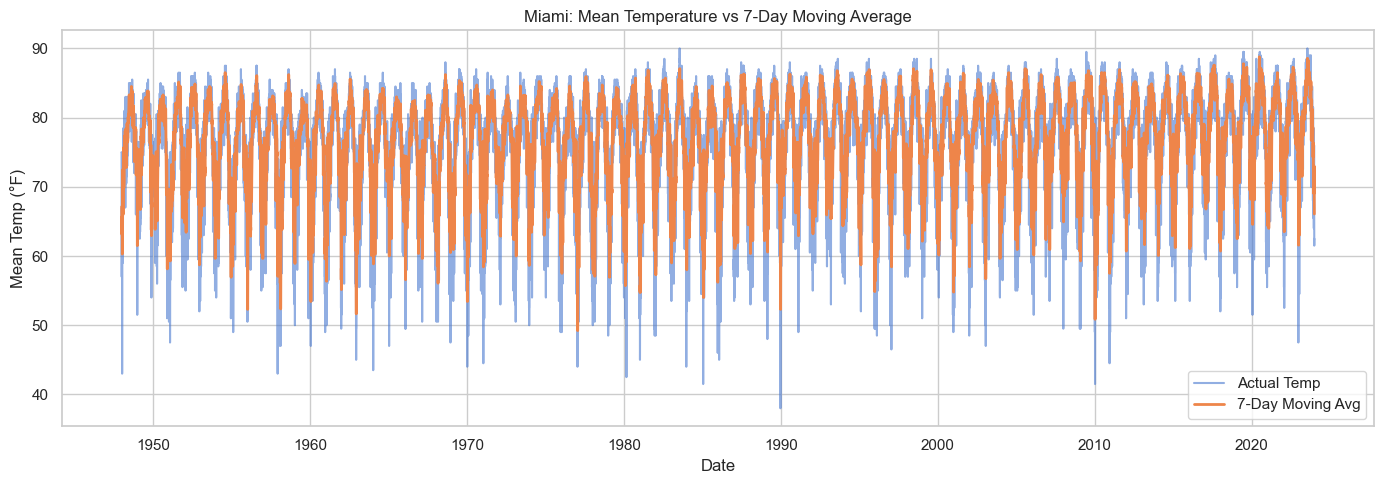

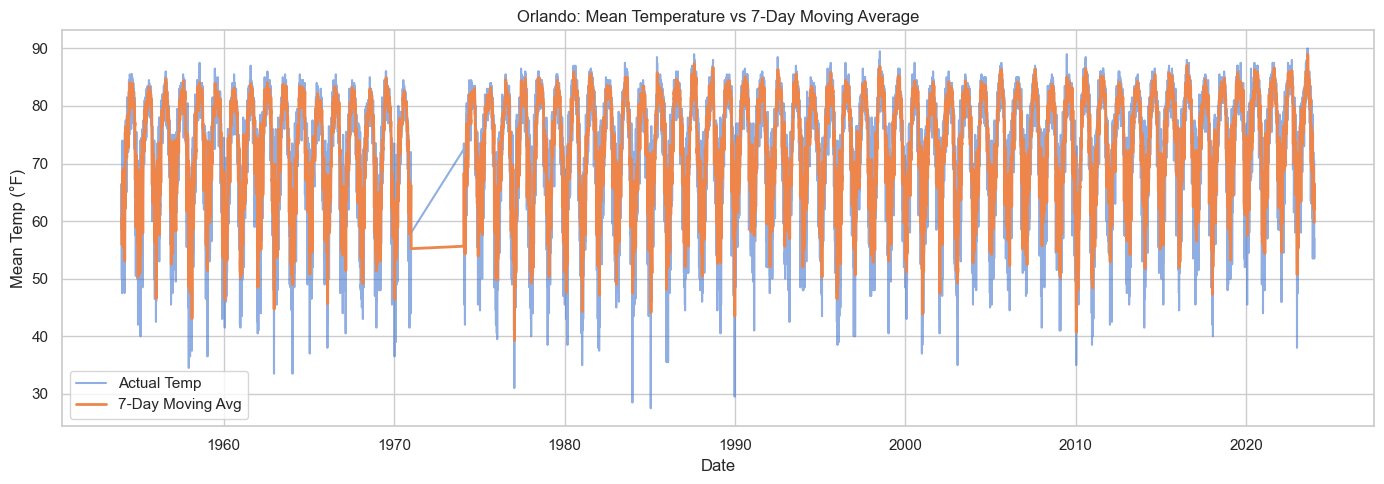

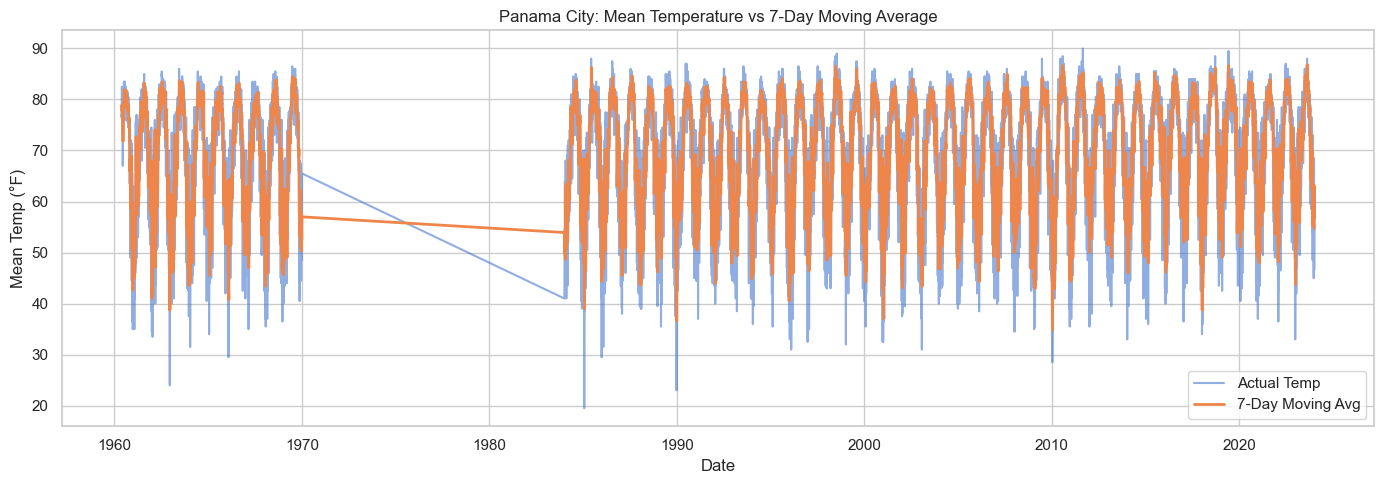

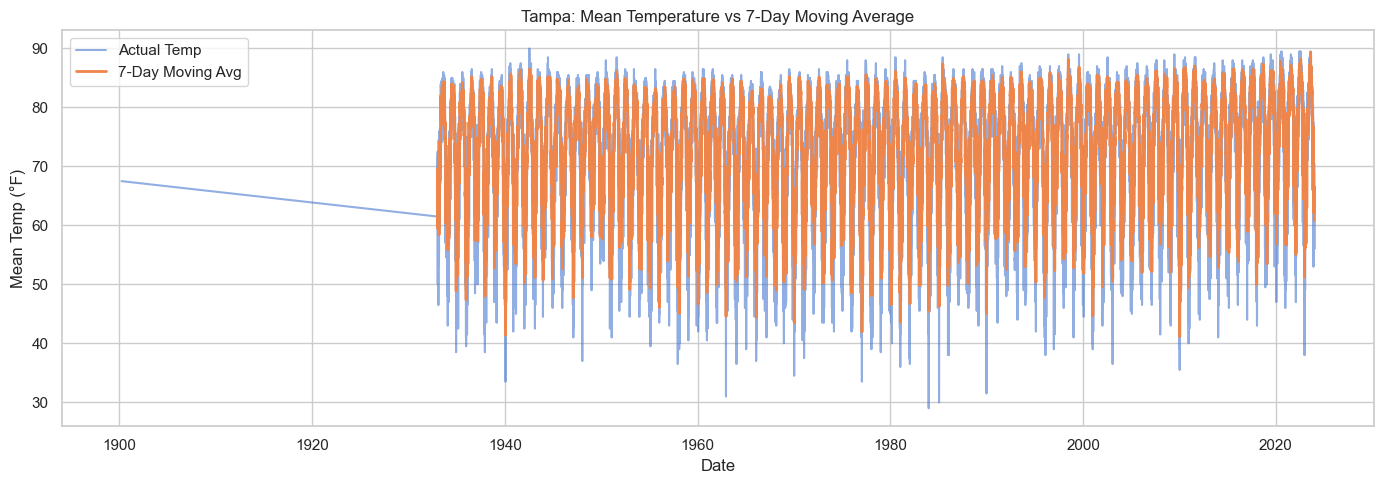

In [13]:
#7 day moving average for each of the cities
city_ma_df = combined_df_clean.copy()
city_ma_df.sort_values(by=["City", "Date"], inplace=True)

city_ma_df["TEMP_7D_MA"] = city_ma_df.groupby("City")["MEAN TEMP"].transform(lambda x: x.rolling(window=7).mean())
city_ma_df["PRECIP_7D_MA"] = city_ma_df.groupby("City")["PRECIPITATION"].transform(lambda x: x.rolling(window=7).mean())

cities = city_ma_df["City"].unique()

for city in cities:
    city_data = city_ma_df[city_ma_df["City"] == city]
    plt.figure(figsize=(14, 5))
    sns.lineplot(data=city_data, x="Date", y="MEAN TEMP", label="Actual Temp", alpha=0.6)
    sns.lineplot(data=city_data, x="Date", y="TEMP_7D_MA", label="7-Day Moving Avg", linewidth=2)
    plt.title(f"{city}: Mean Temperature vs 7-Day Moving Average")
    plt.xlabel("Date")
    plt.ylabel("Mean Temp (°F)")
    plt.legend()
    plt.tight_layout()
    plt.show()
